In [2]:
import sys
import pickle
import numpy as np
import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()  # if not use with this line, "AttributeError: 'int' object has no attribute 'value'" 
#tf.disable_eager_execution()
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

##### Set directory path of codes

In [3]:
new_path = r'/home/users/suihong/GANSimCodes/3. GANSimModel/' 
sys.path.append(new_path)

#### Set directory path of dataset; this directory includes two sub-folders: "TrainingData" and "TestData"

In [4]:
data_dir_test = '/scratch/users/suihong/GANSimData/'

#### Set path to trained GANSim model

In [10]:

network_dir = '/scratch/users/suihong/GANSimData/TrainedModels/test_trained_GANSim/'
network_name = 'network-snapshot-007520.pkl' 

### 1. Fetch test dataset

In [6]:
tf.InteractiveSession()

import dataset
test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', 
                                cond_label = False, cond_well = True, cond_prob = True,
                                labeltypes = [], well_enlarge = True, shuffle_mb = 0, prefetch_mb = 0)
cubeorlabel_dict = test_set.get_minibatch_cubeorlabel_np(minibatch_size = 30, lod = 0)  
realcubes_test = cubeorlabel_dict['real']  # facies model patches
proborwell_dict = test_set.get_minibatch_proborwell_np(minibatch_size = 30, lod = 0)
probcubes_test = proborwell_dict['prob']   # probability patches for facies models
wellfaciescubes_test = proborwell_dict['well']  # well facies patches for facies models


Streaming data using dataset.TFRecordDataset...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [1, 128, 128, 32]
Dynamic range = [0, 2]
Label size    = 0


In [7]:
print(realcubes_test.shape) 
print(wellfaciescubes_test.shape)
print(probcubes_test.shape)

(30, 1, 128, 128, 32)
(30, 1, 128, 128, 32)
(30, 2, 128, 128, 32)


### 2. Import pre-trained GANSim Network

In [11]:
tf.InteractiveSession()
with open(network_dir+network_name, 'rb') as file:
    G, D, Gs = pickle.load(file)  
del G

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [12]:
print(Gs.input_shapes)

print(Gs.output_shapes)

[[None, 8, 12, 12, 12], [None, 0, 12, 12, 12], [None, 2, 128, 128, 32], [None, 2, 128, 128, 32]]
[[None, 3, 128, 128, 32]]


### 3. Evaluation of trained generator with 128x128x32 test data

##### 3.1 Generate 30 facies models for 30 groups of test well facies and probability cubes

In [13]:
wellfacies_loc = np.where(wellfaciescubes_test>0, 1, 0)
wellfacies_fc = (wellfaciescubes_test - 1) * wellfacies_loc
wellfacies_G = np.concatenate([wellfacies_loc, wellfacies_fc], axis = 1)

In [15]:
latents = np.random.RandomState(99999).randn(30, 8, 12, 12, 12)   
labels1 = np.random.RandomState(816).randn(30, 0, 12, 12, 12)  
fakemodel_indicators = Gs.run(latents, labels1, wellfacies_G[:30], probcubes_test[:30]) # indicator cubes

fakemodels = np.expand_dims(np.argmax(fakemodel_indicators, axis = 1), axis = 1) # facies models
print(fakemodels.shape)

(30, 1, 128, 128, 32)


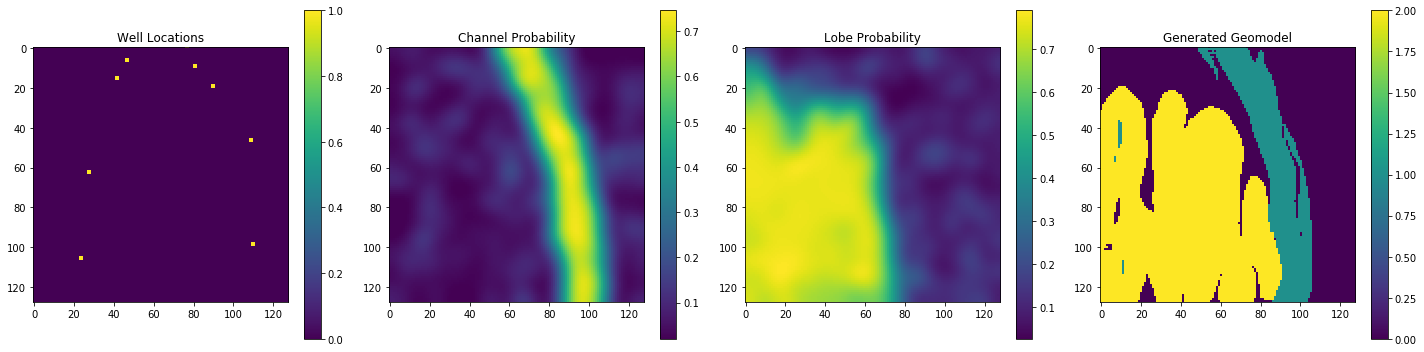

In [20]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(20, 5, forward=True)

# Well Locations
im0 = ax[0].imshow(wellfacies_G[21, 0, :, :, 20].astype(np.float32))
ax[0].set_title('Well Locations')
fig.colorbar(im0, ax=ax[0])

# Channel Probability
im1 = ax[1].imshow(probcubes_test[21, 0, :, :, 20].astype(np.float32))
ax[1].set_title('Channel Probability')
fig.colorbar(im1, ax=ax[1])

# Lobe Probability
im2 = ax[2].imshow(probcubes_test[21, 1, :, :, 20].astype(np.float32))
ax[2].set_title('Lobe Probability')
fig.colorbar(im2, ax=ax[2])

# Generated Geomodel
im3 = ax[3].imshow(fakemodels[21, 0, :, :, 20].astype(np.float32))
ax[3].set_title('Generated Geomodel')
fig.colorbar(im3, ax=ax[3])

plt.tight_layout()
plt.show()


###### Well facies reproduction accuracy calculation

In [21]:
well_repro_acc = np.sum(np.where((fakemodels == wellfacies_G[:, 1:2]) & (wellfacies_G[:, 0:1] == 1.), 1., 0.)) / np.sum(wellfacies_G[:, 0])
print(well_repro_acc)

0.9958133971291866


##### 3.2 Generate 30 facies models for one group of test well facies and probability cubes

In [27]:
test_num = 2  # which group of test data is used

latents = np.random.RandomState(99999).randn(30, 8, 12, 12, 12)   
labels1 = np.random.RandomState(816).randn(30, 0, 12, 12, 12)  
wellfacies_input = np.tile(wellfacies_G[test_num:test_num+1], (30, 1, 1, 1, 1)) # repeat well facies 30 times
prob_input = np.tile(probcubes_test[test_num:test_num+1], (30, 1, 1, 1, 1)) 
fakemodel_indicators = Gs.run(latents, labels1, wellfacies_input, prob_input) # produced indicators
fakemodels = np.expand_dims(np.argmax(fakemodel_indicators, axis = 1), axis = 1) # produced geomodels
print(fakemodels.shape)

freq_ch = np.mean(np.where(fakemodels == 1, 1, 0), axis = 0, keepdims = True)  # calcualted frequency for channels
print(freq_ch.shape)
freq_lobe = np.mean(np.where(fakemodels == 2, 1, 0), axis = 0, keepdims = True)  # calcualted frequency for lobes
print(freq_lobe.shape)

(30, 1, 128, 128, 32)
(1, 1, 128, 128, 32)
(1, 1, 128, 128, 32)


###### Well facies reproduction accuracy calculation

In [28]:
well_repro_acc = np.sum(np.where((fakemodels == wellfacies_input[:, 1:2]) & (wellfacies_input[:, 0:1] == 1.), 1., 0.)) / np.sum(wellfacies_input[:, 0])
print(well_repro_acc)

0.9896990740740741


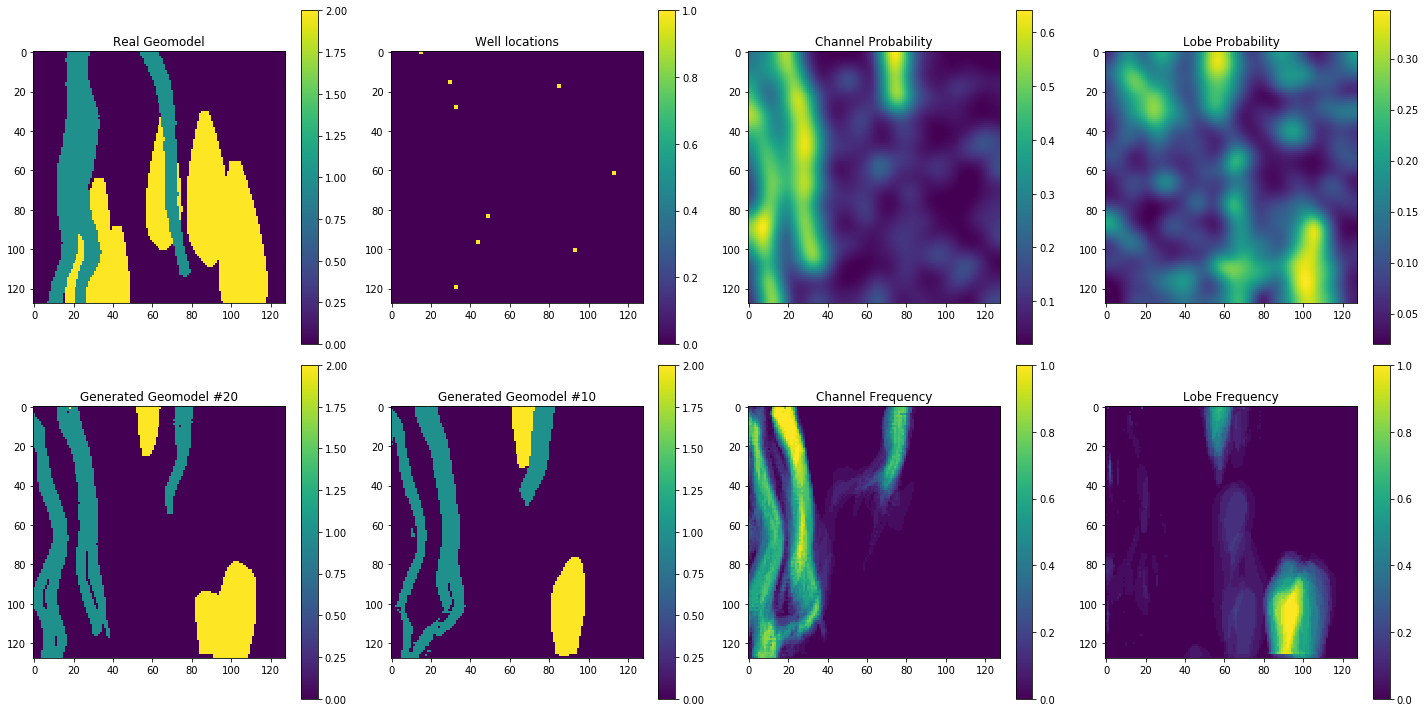

In [40]:
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(20, 10, forward=True)

# Real Geomodel
im0 = ax[0, 0].imshow(realcubes_test[test_num, 0, :, :, 20].astype(np.float32))
ax[0, 0].set_title('Real Geomodel')
fig.colorbar(im0, ax=ax[0, 0])

# Well Facies
im1 = ax[0, 1].imshow(wellfacies_G[test_num, 0, :, :, 20].astype(np.float32))
ax[0, 1].set_title('Well locations')
fig.colorbar(im1, ax=ax[0, 1])

# Channel Probability
im2 = ax[0, 2].imshow(probcubes_test[test_num, 0, :, :, 20].astype(np.float32))
ax[0, 2].set_title('Channel Probability')
fig.colorbar(im2, ax=ax[0, 2])

# Lobe Probability
im3 = ax[0, 3].imshow(probcubes_test[test_num, 1, :, :, 20].astype(np.float32))
ax[0, 3].set_title('Lobe Probability')
fig.colorbar(im3, ax=ax[0, 3])

# Generated Geomodel #5
im4 = ax[1, 0].imshow(fakemodels[20, 0, :, :, 20].astype(np.float32))
ax[1, 0].set_title('Generated Geomodel #20')
fig.colorbar(im4, ax=ax[1, 0])

# Generated Geomodel #10
im5 = ax[1, 1].imshow(fakemodels[10, 0, :, :, 20].astype(np.float32))
ax[1, 1].set_title('Generated Geomodel #10')
fig.colorbar(im5, ax=ax[1, 1])

# Channel Frequency
im6 = ax[1, 2].imshow(freq_ch[0, 0, :, :, 20].astype(np.float32))
ax[1, 2].set_title('Channel Frequency')
fig.colorbar(im6, ax=ax[1, 2])

# Lobe Frequency
im7 = ax[1, 3].imshow(freq_lobe[0, 0, :, :, 20].astype(np.float32))
ax[1, 3].set_title('Lobe Frequency')
fig.colorbar(im7, ax=ax[1, 3])

plt.tight_layout()
plt.show()


###### Save into Gslib format for visualization in Petrel

In [41]:
##### Save conditioning well facies data into Petrel-readable files (Gslib)

onecube = np.zeros([32, 128, 128])
coords = np.argwhere(onecube>-1)
coords_output = np.zeros(coords.shape)
coords_output[:,0] = coords[:,2]+1
coords_output[:,1] = coords[:,1]+1
coords_output[:,2] = 32 - coords[:,0]
coords_output = coords_output.astype(np.int16)

exampled_fm = np.where(wellfacies_G[test_num:test_num+1, 0:1], wellfacies_G[test_num:test_num+1, 1:2], 255)
exampled_fm = exampled_fm[:,:,::-1]
exampled_fm_output = exampled_fm.transpose(0,1,4,2,3)[:,:,::-1,::-1,:].reshape(-1, coords.shape[0]).T.astype(np.int)
exampled_fm_output_txt = np.concatenate((coords_output, exampled_fm_output), axis = 1)

exampled_fm_fname =network_dir + 'ConditoingWellFaciesdata.txt'
np.savetxt(exampled_fm_fname , exampled_fm_output_txt, fmt='%i', newline='\n')   # "%03d" + "%.10f"*7

with open(exampled_fm_fname, "r") as f:
    contents = f.readlines()
lines = 'PETREL: Properties\n'+'4\n'+'i_index unit1 scale1\n'+'j_index unit1 scale1\n'+'k_index unit1 scale1\n'+\
'Facies unit1 scale1\n'*1
contents.insert(0, lines)
with open(exampled_fm_fname, "w") as f:
    contents = "".join(contents)
    f.write(contents)

In [42]:
##### Save conditioning probability cubes into Petrel-readable files

exampled_fm = probcubes_test[test_num:test_num+1, :, ::-1]
exampled_fm_output = exampled_fm.transpose(0,1,4,2,3)[:,:,::-1,::-1,:].reshape(-1, coords.shape[0]).T.astype(np.float16)
exampled_fm_output_txt = np.concatenate((coords_output, exampled_fm_output), axis = 1)

exampled_fm_fname =network_dir + 'ConditoingProbData.txt'
np.savetxt(exampled_fm_fname , exampled_fm_output_txt, fmt="%03d " * 3 + "%.2f "*2, newline='\n')   # "%03d" + "%.10f"*7

with open(exampled_fm_fname, "r") as f:
    contents = f.readlines()
lines = 'PETREL: Properties\n'+'5\n'+'i_index unit1 scale1\n'+'j_index unit1 scale1\n'+'k_index unit1 scale1\n'+\
'Probability unit1 scale1\n'*2
contents.insert(0, lines)
with open(exampled_fm_fname, "w") as f:
    contents = "".join(contents)
    f.write(contents)

In [43]:
##### Save 30 generated facies models into Petrel-readable files

exampled_fm = fakemodels[:,:,::-1]
exampled_fm_output = exampled_fm.transpose(0,1,4,2,3)[:,:,::-1,::-1,:].reshape(-1, coords.shape[0]).T.astype(np.int)
exampled_fm_output_txt = np.concatenate((coords_output, exampled_fm_output), axis = 1)

exampled_fm_fname =network_dir + '30GeneatedFaciesModels_8160_SameCondition_' + str(test_num) + '.txt'
np.savetxt(exampled_fm_fname , exampled_fm_output_txt, fmt='%i', newline='\n')   # "%03d" + "%.10f"*7

with open(exampled_fm_fname, "r") as f:
    contents = f.readlines()
lines = 'PETREL: Properties\n'+'33\n'+'i_index unit1 scale1\n'+'j_index unit1 scale1\n'+'k_index unit1 scale1\n'+\
'Facies unit1 scale1\n'*30
contents.insert(0, lines)
with open(exampled_fm_fname, "w") as f:
    contents = "".join(contents)
    f.write(contents)

In [44]:
##### Save frequency cubes into Petrel-readable files

exampled_fm = np.concatenate((freq_ch, freq_lobe), axis = 0)
exampled_fm = exampled_fm[:,:,::-1]
exampled_fm_output = exampled_fm.transpose(0,1,4,2,3)[:,:,::-1,::-1,:].reshape(-1, coords.shape[0]).T.astype(np.float16)
exampled_fm_output_txt = np.concatenate((coords_output, exampled_fm_output), axis = 1)

exampled_fm_fname =network_dir + 'Frequency_SameCondition_8160new_' + str(test_num) + '.txt'
np.savetxt(exampled_fm_fname , exampled_fm_output_txt, fmt="%03d " * 3 + "%.2f "*2, newline='\n')   # "%03d" + "%.10f"*7

with open(exampled_fm_fname, "r") as f:
    contents = f.readlines()
lines = 'PETREL: Properties\n'+'5\n'+'i_index unit1 scale1\n'+'j_index unit1 scale1\n'+'k_index unit1 scale1\n'+\
'Probability unit1 scale1\n'*2
contents.insert(0, lines)
with open(exampled_fm_fname, "w") as f:
    contents = "".join(contents)
    f.write(contents)
